In [1]:
import torch
import random
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import requests
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# data_link = 'https://raw.githubusercontent.com/karpathy/makemore/master/names.txt'
# file = requests.get(data_link)
# with open('names.txt', 'wb') as f:
#   f.write(file.content)

# words = open('names.txt', 'r').read().splitlines()

#alternative approach
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

words = open('names.txt', 'r').read().splitlines()

--2024-06-14 16:08:53--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.004s  

2024-06-14 16:08:53 (59.1 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
# comment this part in the repo
word_count = len(words)
max_length = max(len(word) for word in words)
min_length = min(len(word) for word in words)

print(f"{word_count=} \n {max_length=} \n {min_length=}")

word_count=32033 
 max_length=15 
 min_length=2


## Bigram Implementation

In [4]:
# create a lookup table for strings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}


In [5]:
block_size = 8

def build_dataset(words):
  X, Y = [], []
  for word in words:
    context = [0] * block_size
    for ch in word + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182547, 8]) torch.Size([182547])
torch.Size([23012, 8]) torch.Size([23012])
torch.Size([22587, 8]) torch.Size([22587])


In [6]:
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
# model architecture

n_embed = 24
n_hidden = 200
vocab_size = len(stoi.values())
num_layers = 1     # number of LSTM layers
#block_size = 8

#nn.Module
class LSTMModel(nn.Module):
  def __init__(self, n_embed, n_hidden, output_size, num_layers):
    super(LSTMModel, self).__init__()   #making LSTMMOdel inherit all the properties of nn.Module
    self.hidden_size = n_hidden
    self.num_layers = num_layers
    self.embed = nn.Embedding(vocab_size, n_embed)
    self.lstm = nn.LSTM(n_embed, n_hidden, num_layers, batch_first=True)
    self.linear = nn.Linear(n_hidden, vocab_size)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) #to the device of x
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    x = self.embed(x)
    out, _ = self.lstm(x, (h0, c0))
    out = self.linear(out[:, -1, :])
    return out

  def parameters(self):
    return list(self.lstm.parameters()) + list(self.linear.parameters()) + list(self.embed.parameters())

model = LSTMModel(n_embed, n_hidden, vocab_size, num_layers)
model = model.to(device)

with torch.no_grad():
  model.linear.weight *= 0.1 # the model is a class object

print(sum(p.nelement() for p in model.parameters()))  # p is a tensor, we can do p.grad() but we'll have to do nelement() to count parameters

for p in model.parameters():
  p.requires_grad = True

params = model.parameters()
for param in params:
    print(param.shape)



186875
torch.Size([800, 24])
torch.Size([800, 200])
torch.Size([800])
torch.Size([800])
torch.Size([27, 200])
torch.Size([27])
torch.Size([27, 24])


In [8]:
# actual training process
max_steps = 100000
batch_size = 32
lossi = []
for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]
  Xb = Xb.to(device)
  Yb = Yb.to(device)

  # pass xb through the model
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backprop
  for p in model.parameters():
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01
  for p in model.parameters():
    p.data += -lr * p.grad
  lossi.append(loss.log10().item())
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

      0/ 100000: 3.3138
  10000/ 100000: 2.3209
  20000/ 100000: 1.9411
  30000/ 100000: 1.9301
  40000/ 100000: 1.5920
  50000/ 100000: 2.1633
  60000/ 100000: 2.0979
  70000/ 100000: 2.0850
  80000/ 100000: 1.9263
  90000/ 100000: 1.7709


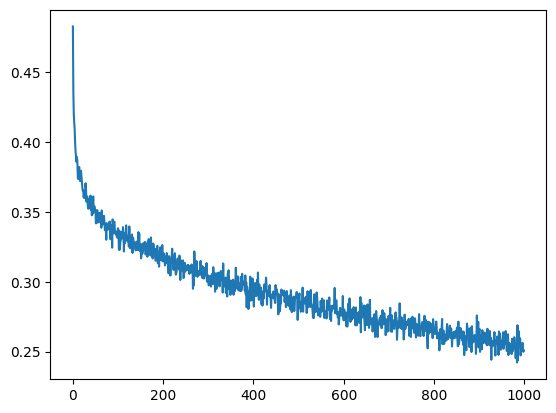

In [9]:
plt.plot(torch.tensor(lossi).view(-1, 100).mean(1))

In [10]:
# set out of training mode

# #using our custom Sequential
# for layer in model.layers():
#   layer.eval() or layer.training = False

# using torch.nn.Sequential
model.eval()

print(model.training)

False


In [11]:
# evaluation on entire dataset

@torch.no_grad()   # for faster operation
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  x = x.to(device)
  y = y.to(device)
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(f'{split} loss: {loss.item():.4f}')

split_loss('train')
split_loss('val')

train loss: 1.8057
val loss: 1.9779


In [12]:
# sampling from the model
g = torch.Generator().manual_seed(1234543)
for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    # remember to preserve first dim of context
    context_tensor = torch.tensor([context], device=device)
    logits = model(context_tensor)
    probs = F.softmax(logits, dim=1)


    ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
    out.append(ix)
    context = context[1:] + [ix]
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))



krislynn.
viran.
endreas.
everlynne.
khilo.
fiora.
shevin.
isah.
kamerin.
wylin.
omony.
kuntrell.
sai.
sminiyah.
mana.
krushan.
kharvi.
sterlen.
roselin.
edi.
